In [1]:
# ----------------------------------------------------------------------
# Bernstein-Vazirani (BV) Algorithm – Clean vs Malicious Dataset (Qiskit Simulation)
# ----------------------------------------------------------------------

# This notebook implements the Bernstein-Vazirani algorithm using Qiskit
# and simulates both clean and Trojan-altered quantum circuits to generate
# a labeled dataset for security analysis and anomaly detection.

# Objective:
# - Generate 10 clean BV circuits for randomly chosen hidden strings
# - Generate 10 malicious BV circuits with corrupted encoding or extra gates
# - Use IBM Qiskit Runtime to simulate all circuits and extract analytical features

# Dataset Composition:
# - Clean circuits labeled as 0
# - Malicious circuits labeled as 1
# - Each entry includes depth, gate counts, entropy, and output uniqueness

# Threat Model:
# - Malicious circuit variations introduce:
#     • Incorrect hidden string encodings (wrong CX placements)
#     • Injection of logic gates (e.g., X, CX, CCX) before or after oracle
#     • Distortion of final Hadamard or measurement layers

# Visualization & Analysis:
# - Output histograms and circuit diagrams saved
# - Final dataset stored as CSV
# - Class correlation heatmap used for anomaly detection model insights

# Environment:
# - Qiskit + IBM Runtime
# - Matplotlib, Seaborn, Pandas, NumPy for visualization and data handling

# This notebook supports secure quantum computing research by modeling
# optimization circuit behaviors under clean and adversarial settings.

# Author: Zeeshan Ajmal

In [25]:
# Core Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as norm_sampler

# Visualization and analysis tools
%matplotlib inline
from qiskit.visualization import plot_histogram, plot_circuit_layout
import matplotlib.pyplot as plt
from qiskit.quantum_info import shannon_entropy


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import math

from collections import Counter
from IPython.display import display


In [5]:
# -----------------------------------------------
# Initializing IBM Quantum Runtime Account
# -----------------------------------------------

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='ff1dde434d0dcec5608d0b0166f3df690e5b8258114b55d50805fe2c5c25d03a520f7551cd363d5295b421ab19908870fc00cdfb57a074f0a7eaa6c9ff2fa9e6'
)

# Author: Zeeshan


In [6]:
## Clean Bernstein–Vazirani Circuit Variations
#
# The Bernstein–Vazirani (BV) algorithm is used to identify a hidden bitstring embedded in a quantum oracle. In this section, we create 10 clean circuit variations of BV, each corresponding to a unique hidden string (e.g., `000`, `011`, `101`, etc.).
#
# These circuits serve as the "non-malicious" baseline. Their structures are used later for comparison against maliciously altered versions to train anomaly detection models.


In [7]:
# Function to create a clean BV circuit for a given hidden string
def generate_bv_clean_circuit(hidden_string):
    n = len(hidden_string)
    qc = QuantumCircuit(n + 1, n)

    # Initialize last qubit to |1⟩
    qc.x(n)
    qc.h(range(n + 1))

    # Oracle implementation
    for i, bit in enumerate(reversed(hidden_string)):
        if bit == '1':
            qc.cx(i, n)

    # Apply final Hadamard
    qc.h(range(n))

    # Measure first n qubits
    qc.measure(range(n), range(n))

    return qc

# Define 10 target bitstrings
bv_targets = ['000', '001', '010', '011', '100', '101', '110', '111', '101', '011']

# Store clean BV circuits
bv_clean_circuits = {}

# Generate and store circuits
for i, target in enumerate(bv_targets):
    name = f"bv_clean_{i}"
    bv_clean_circuits[name] = generate_bv_clean_circuit(target)


In [11]:
# Set up the backend (IBM real or simulator)
backend = service.backend("ibm_brisbane")  # or "ibmq_qasm_simulator" if local testing


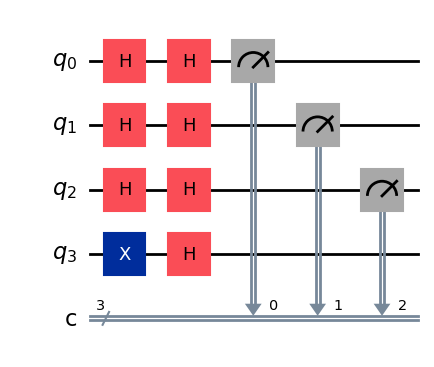

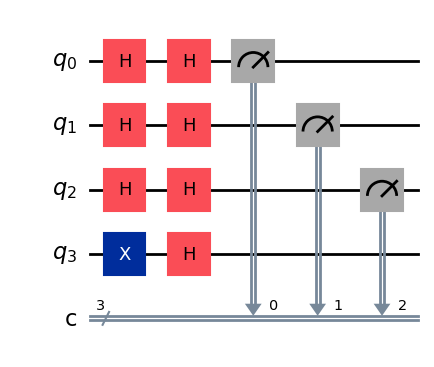

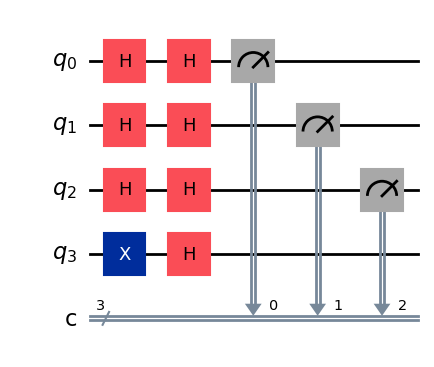

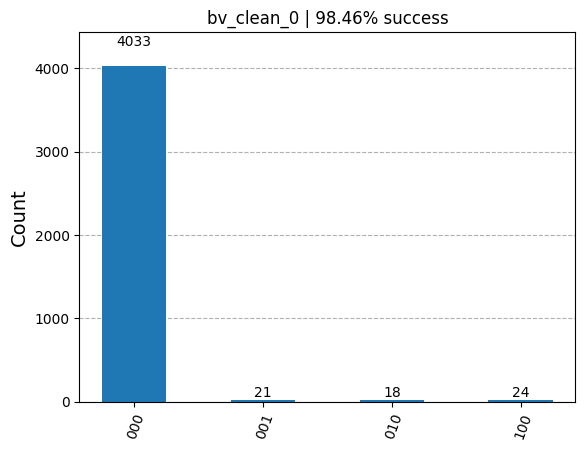

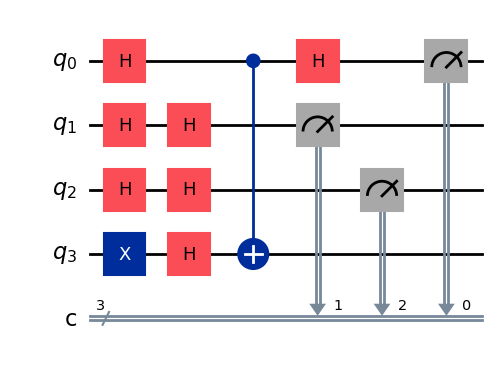

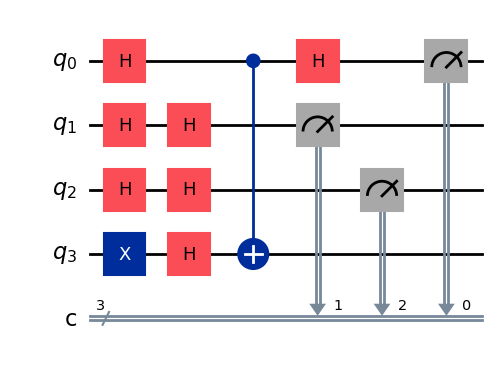

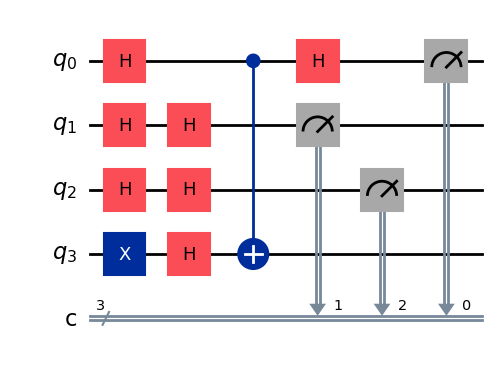

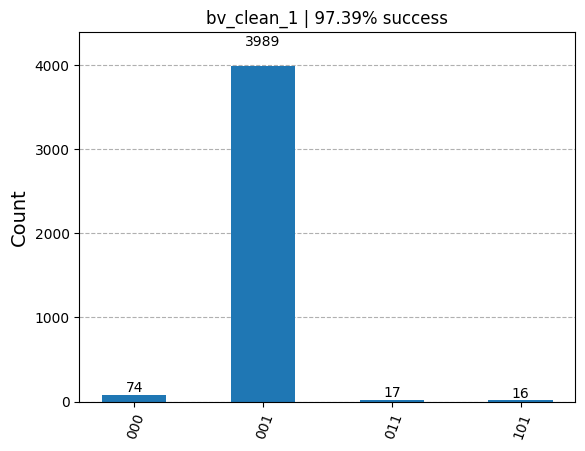

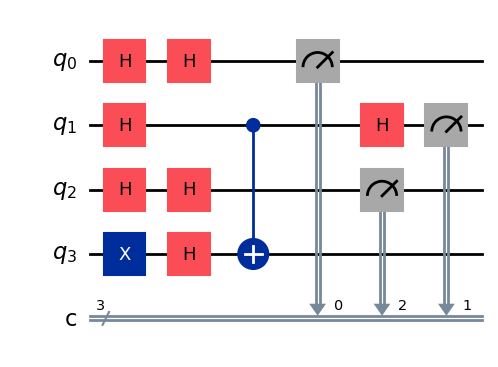

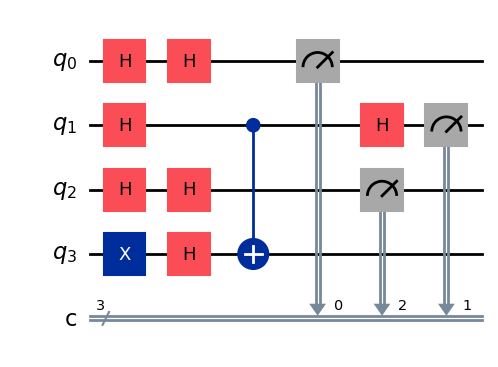

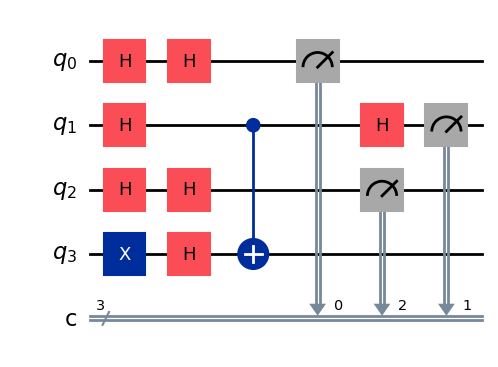

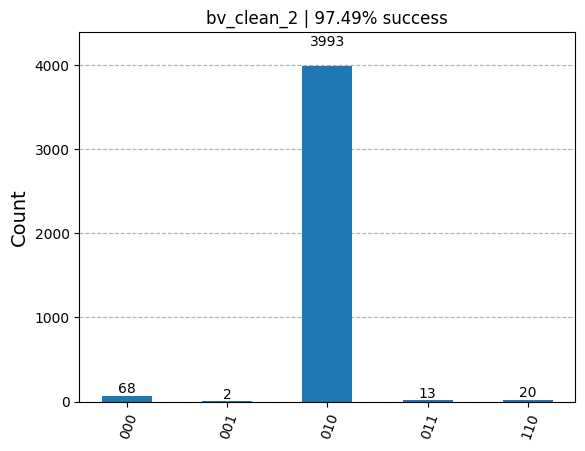

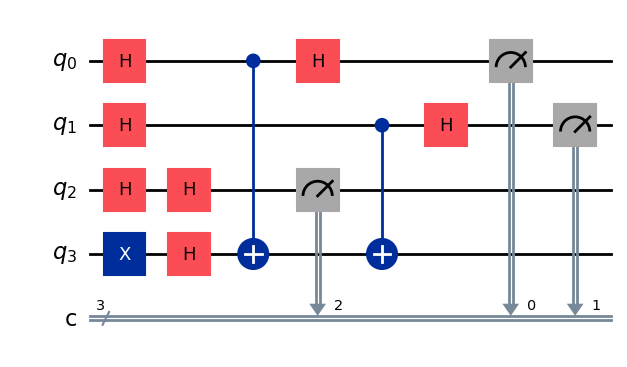

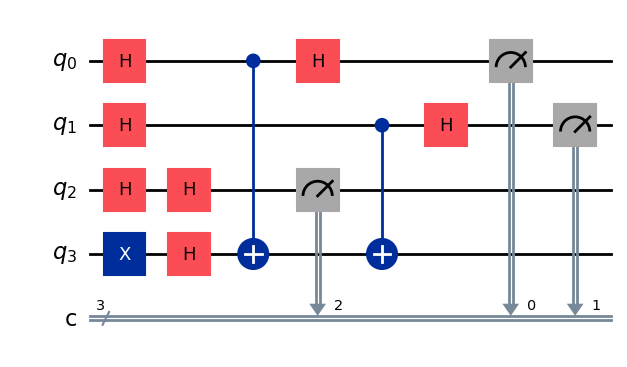

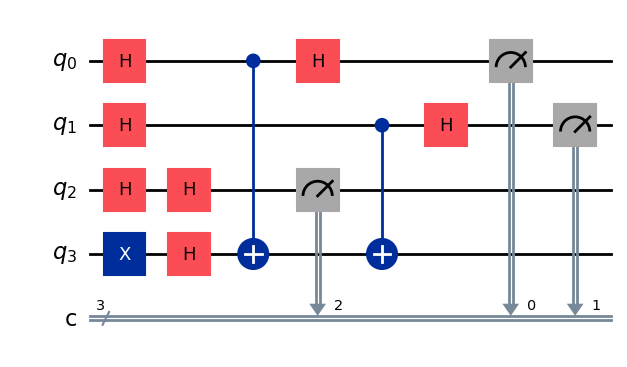

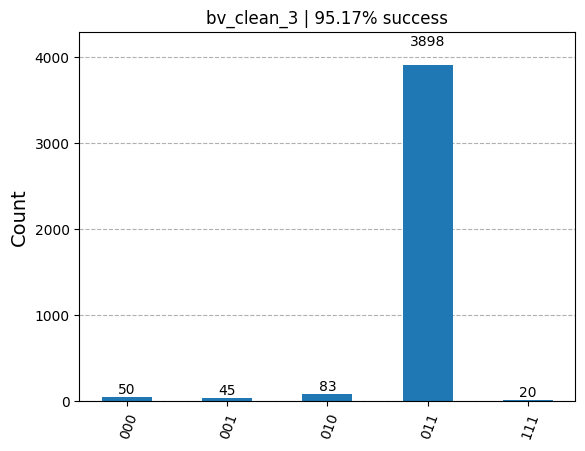

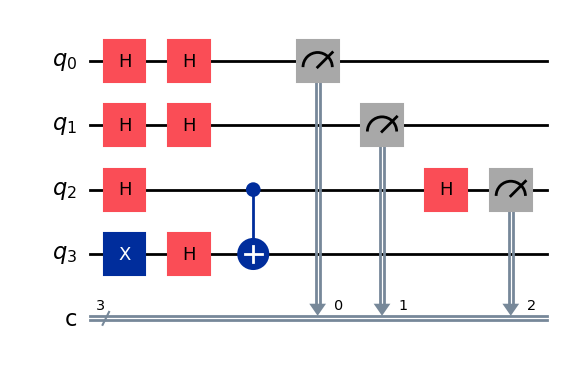

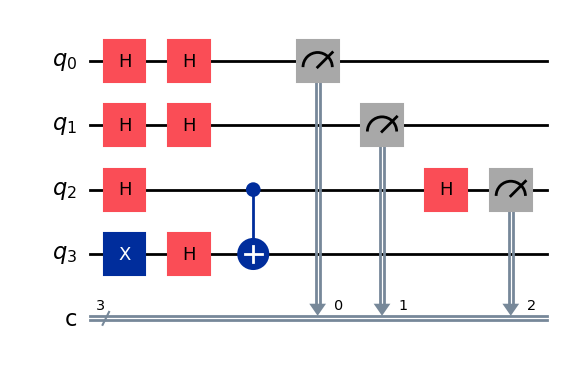

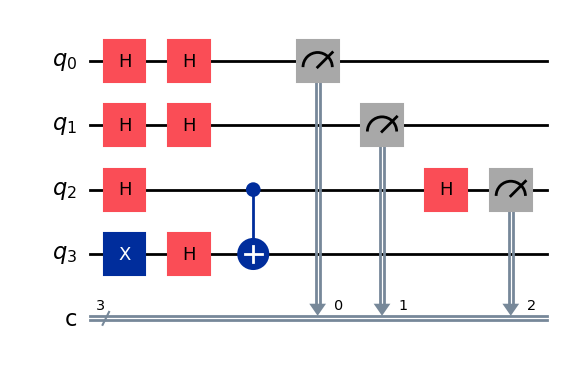

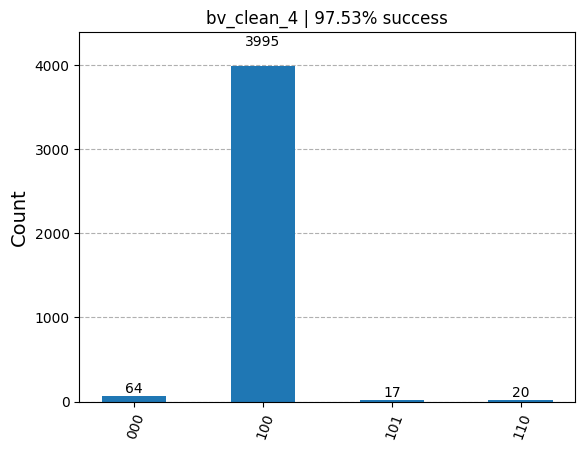

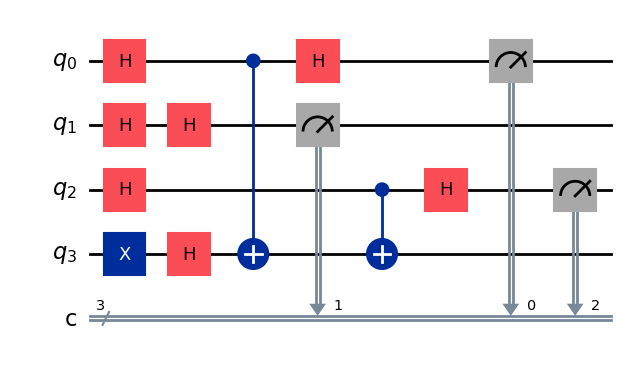

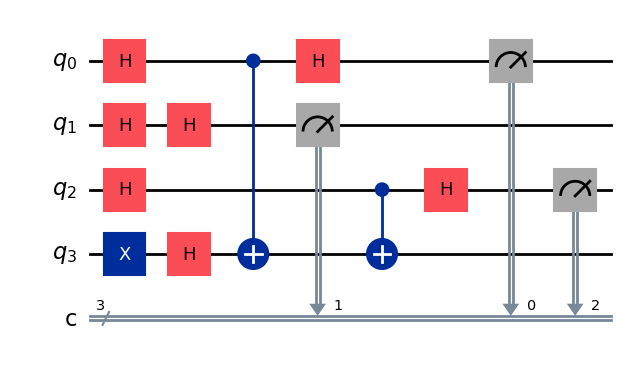

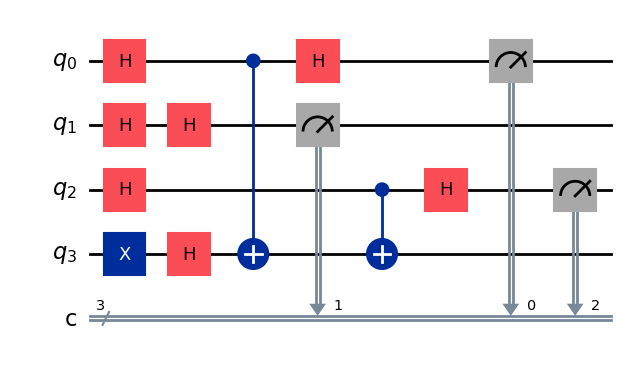

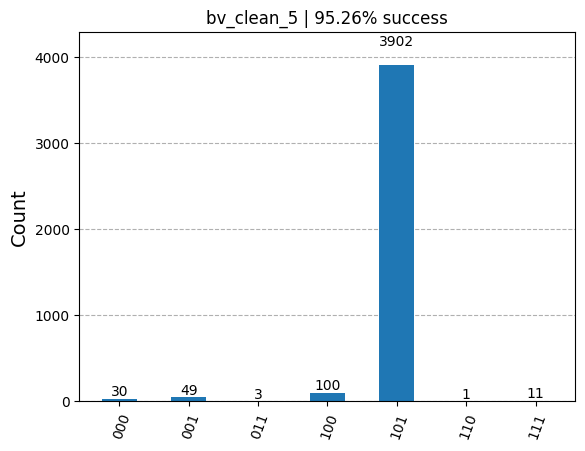

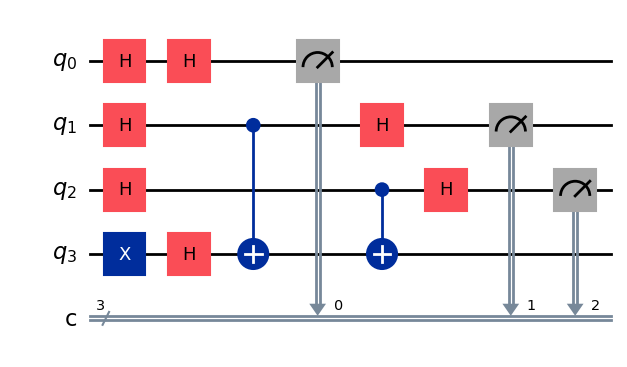

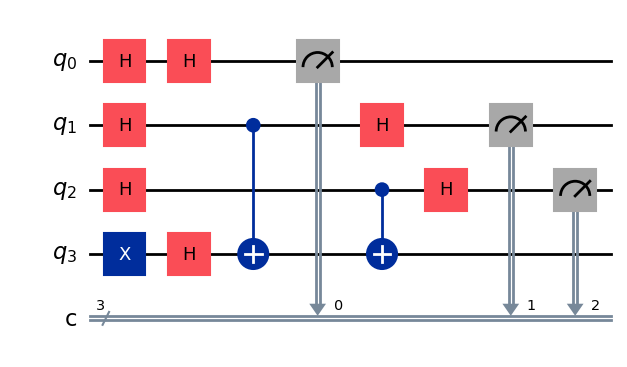

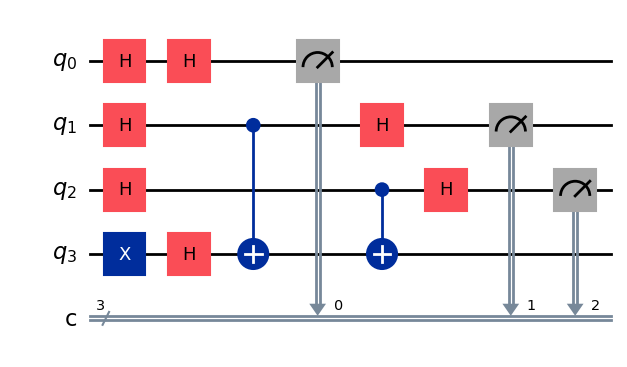

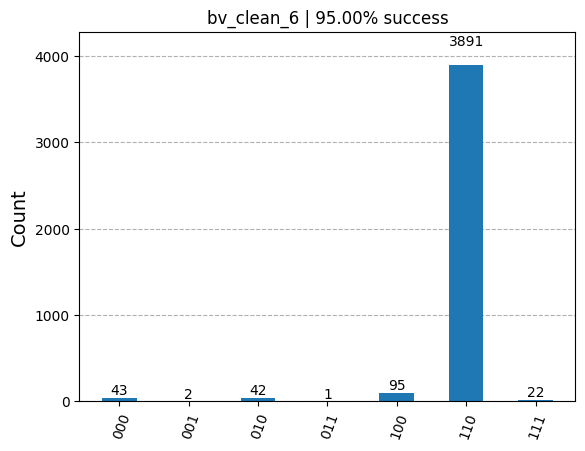

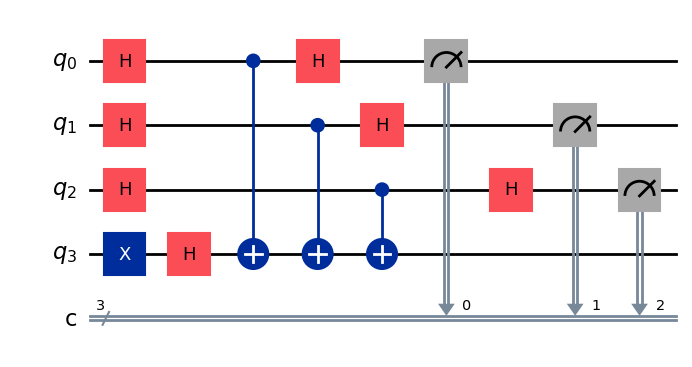

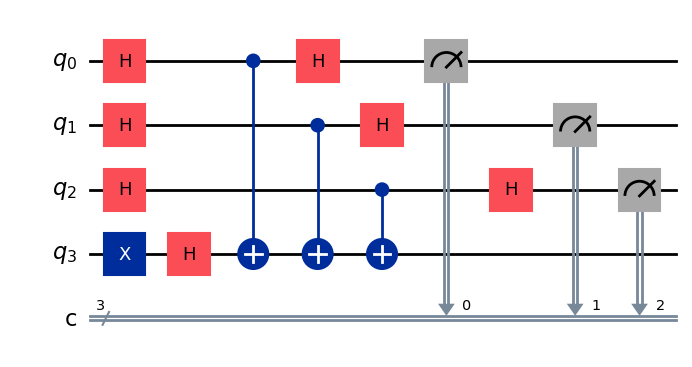

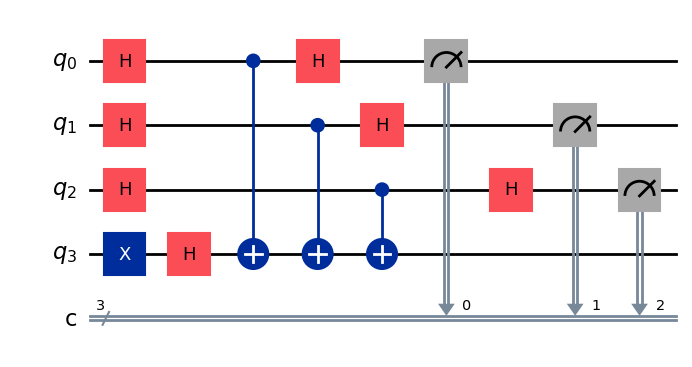

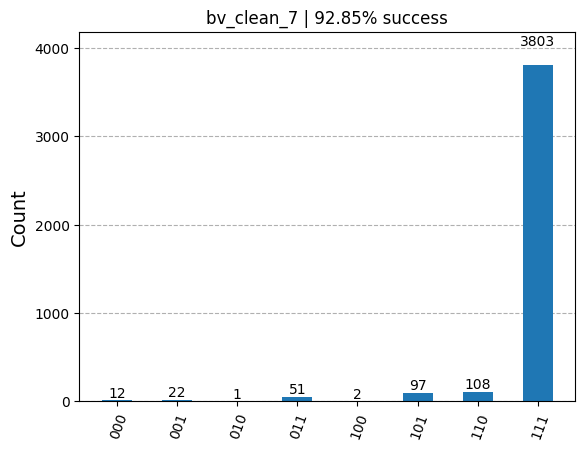

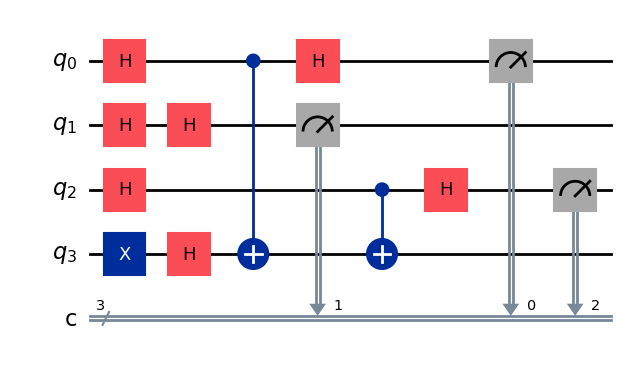

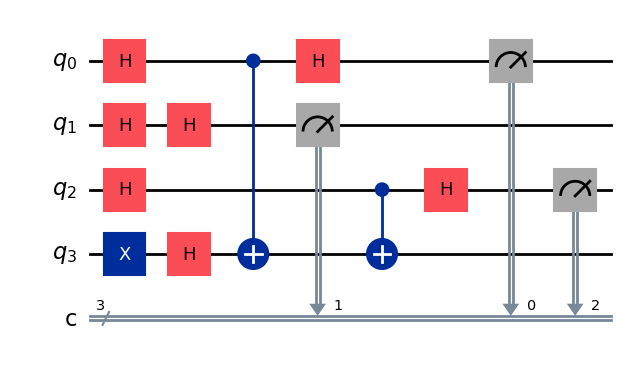

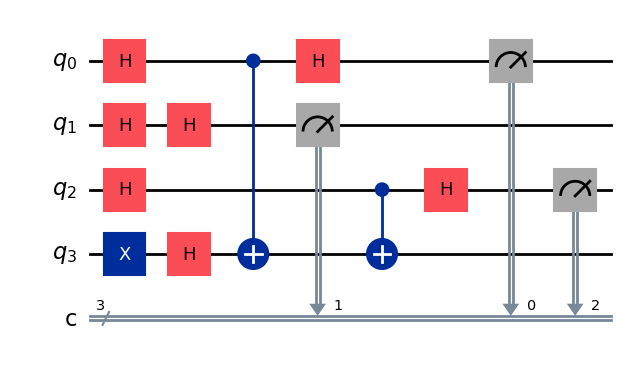

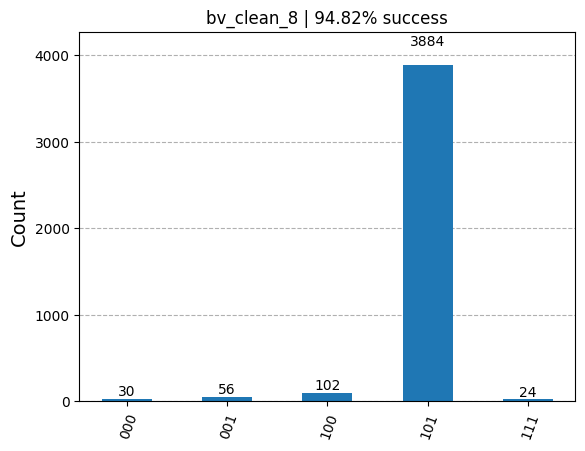

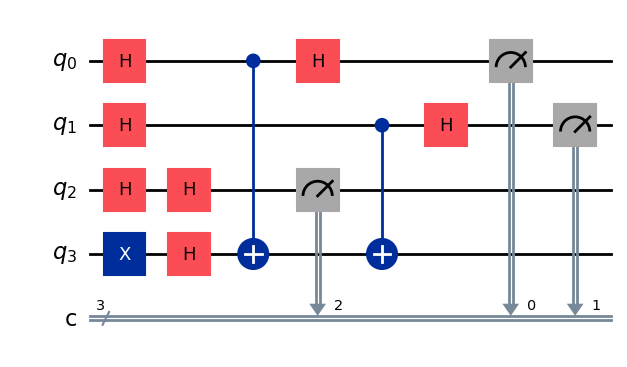

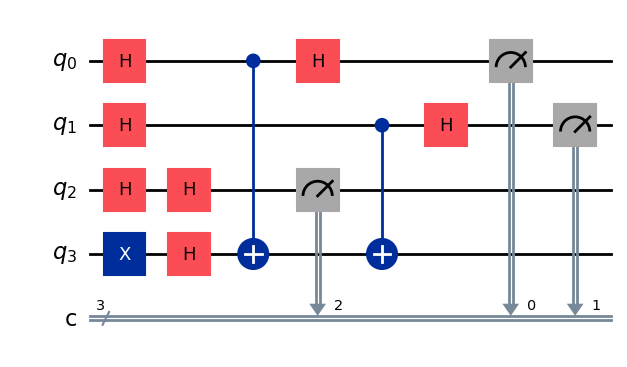

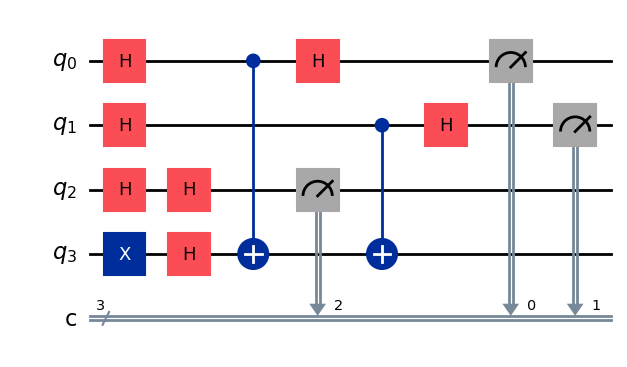

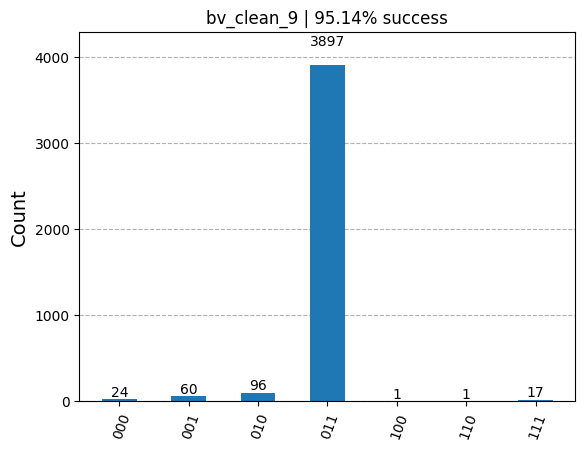

bv_clean_0 | State: 000 | Success Rate: 98.46%
bv_clean_1 | State: 001 | Success Rate: 97.39%
bv_clean_2 | State: 010 | Success Rate: 97.49%
bv_clean_3 | State: 011 | Success Rate: 95.17%
bv_clean_4 | State: 100 | Success Rate: 97.53%
bv_clean_5 | State: 101 | Success Rate: 95.26%
bv_clean_6 | State: 110 | Success Rate: 95.00%
bv_clean_7 | State: 111 | Success Rate: 92.85%
bv_clean_8 | State: 101 | Success Rate: 94.82%
bv_clean_9 | State: 011 | Success Rate: 95.14%


In [21]:
import os
from qiskit.visualization import plot_histogram
from IPython.display import display
import matplotlib.pyplot as plt

# Create folders
os.makedirs("bv_clean_histograms", exist_ok=True)
os.makedirs("bv_clean_circuits", exist_ok=True)

# Backend setup
backend = service.backend("ibm_brisbane")
bv_clean_results = []

# Run and process each circuit
for name, circuit in bv_clean_circuits.items():
    # Save circuit diagram
    circuit.draw("mpl", filename=f"bv_clean_circuits/{name}.png")
    display(circuit.draw("mpl"))

    # Transpile and execute
    transpiled = transpile(circuit, backend=backend)
    sampler = norm_sampler(backend)
    job = sampler.run([transpiled])
    result = job.result()

    # Dynamic classical register extraction
    reg_name = list(result[0].data.__dict__.keys())[0]  # usually 'meas' or 'c'
    counts = getattr(result[0].data, reg_name).get_counts()

    # Analyze results
    success_state = max(counts, key=counts.get)
    percentage = counts[success_state] / sum(counts.values()) * 100

    # Save and show histogram
    fig = plot_histogram(counts, title=f"{name} | {percentage:.2f}% success")
    fig.savefig(f"bv_clean_histograms/{name}_hist.png")
    plt.show()

    # Save result info
    bv_clean_results.append({
        "name": name,
        "success_state": success_state,
        "success_rate": percentage
    })

# Print summary
for res in bv_clean_results:
    print(f"{res['name']} | State: {res['success_state']} | Success Rate: {res['success_rate']:.2f}%")


In [23]:
# Feature Extraction Function for BV
def extract_features(circuit_name, circuit, result, label):
    ops = circuit.count_ops()
    num_cx = ops.get('cx', 0)
    num_h = ops.get('h', 0)
    num_x = ops.get('x', 0)
    num_ccx = ops.get('ccx', 0)
    depth = circuit.depth()
    total_gates = sum(ops.values())

    # Convert measurement result to probability distribution
    counts = result[0].data.c.get_counts()
    probs = np.array(list(counts.values()))
    probs = probs / probs.sum()

    # Measurement-based features
    success_state = max(counts, key=counts.get)
    success_rate = counts[success_state] / sum(counts.values()) * 100
    entropy = shannon_entropy(probs, base=2)
    unique_states = len(counts)

    return {
        "name": circuit_name,
        "depth": depth,
        "cx": num_cx,
        "h": num_h,
        "x": num_x,
        "ccx": num_ccx,
        "total_gates": total_gates,
        "success_rate": success_rate,
        "entropy": entropy,
        "unique_states": unique_states,
        "label": label
    }


In [26]:
# Generate BV clean dataset and save to CSV
bv_dataset = []

for i in range(10):
    name = f"bv_clean_{i}"
    circuit = bv_clean_circuits[name]
    
    transpiled = transpile(circuit, backend=backend)
    sampler = norm_sampler(backend)
    job = sampler.run([transpiled])
    result = job.result()

    features = extract_features(name, circuit, result, label=0)
    bv_dataset.append(features)

# Convert to DataFrame and export
df_bv_clean = pd.DataFrame(bv_dataset)
print(df_bv_clean)
df_bv_clean.to_csv("bv_clean_dataset.csv", index=False)


         name  depth  cx  h  x  ccx  total_gates  success_rate   entropy  \
0  bv_clean_0      3   0  7  1    0           11     98.974609  0.098724   
1  bv_clean_1      5   1  7  1    0           12     97.192383  0.219420   
2  bv_clean_2      5   1  7  1    0           12     97.534180  0.200430   
3  bv_clean_3      6   2  7  1    0           13     95.019531  0.373169   
4  bv_clean_4      5   1  7  1    0           12     97.509766  0.197732   
5  bv_clean_5      6   2  7  1    0           13     95.043945  0.375829   
6  bv_clean_6      6   2  7  1    0           13     95.141602  0.367885   
7  bv_clean_7      7   3  7  1    0           14     92.065430  0.575300   
8  bv_clean_8      6   2  7  1    0           13     94.726562  0.392668   
9  bv_clean_9      6   2  7  1    0           13     94.873047  0.381425   

   unique_states  label  
0              4      0  
1              5      0  
2              4      0  
3              6      0  
4              5      0  
5      

In [27]:
# --------------------------------------------------
# Malicious Bernstein-Vazirani Circuit Generation (Trojan Simulation)
# --------------------------------------------------

# This section generates 10 corrupted BV circuits by introducing Trojan logic
# or adversarial gate modifications to compromise the hidden bitstring encoding.

# Attack Simulation Strategies:
# 1. Oracle corruption: Place incorrect CX gates or skip certain bitstring indices
# 2. Pre-oracle interference: Add RX, X, or CX gates before Hadamards or oracle
# 3. Post-oracle tampering: Modify output qubit interactions or add CCX noise
# 4. Decoherence mimicry: Duplicate existing gates or introduce unnecessary entanglement
# 5. Measurement masking: Inject gate operations before measurement

# Objective:
# - Simulate semantically altered circuits with minimal structural deviation
# - All samples are labeled as `1` (malicious) for supervised learning
# - Used to benchmark classifier performance on quantum integrity detection

# These adversarial circuits are integral to testing the security resilience
# of early-stage quantum devices and hybrid ML detection pipelines.


In [28]:
# Function to generate a malicious version of the BV circuit
def generate_bv_malicious_variation(index):
    qc = QuantumCircuit(3)

    # Step 1: Superposition
    qc.h([0, 1, 2])

    # Step 2: Inject malicious behavior (variation based on index)
    if index == 0:
        qc.x(0)
    elif index == 1:
        qc.h(2)
    elif index == 2:
        qc.cx(0, 2)
    elif index == 3:
        qc.ccx(0, 1, 2)
    elif index == 4:
        qc.z(1)
    elif index == 5:
        qc.cx(1, 0)
    elif index == 6:
        qc.swap(0, 2)
    elif index == 7:
        qc.s(1)
    elif index == 8:
        qc.x(0)
        qc.x(2)
    elif index == 9:
        qc.h(0)
        qc.h(1)
        qc.h(2)

    # Optional Step: add random logic noise
    qc.barrier()

    # Step 3: Apply inverse superposition
    qc.h([0, 1, 2])

    # Step 4: Measurement
    qc.measure_all()

    return qc

# Dictionary to hold the malicious BV circuits
bv_malicious_circuits = {}

# Generate 10 malicious variations
for i in range(10):
    bv_malicious_circuits[f"bv_malicious_{i}"] = generate_bv_malicious_variation(i)


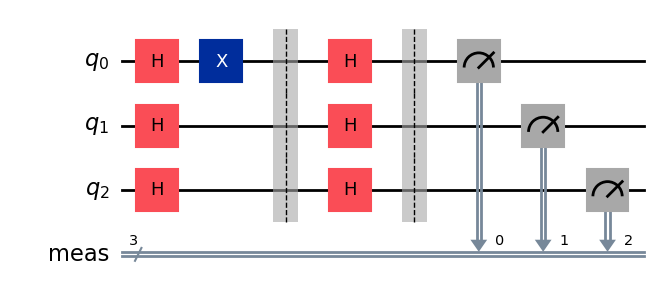

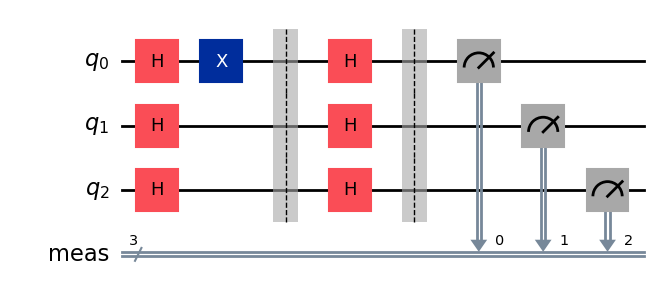

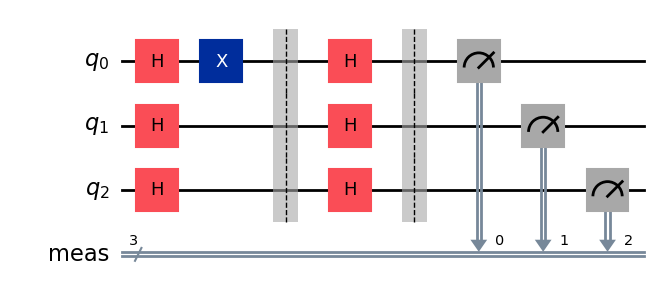

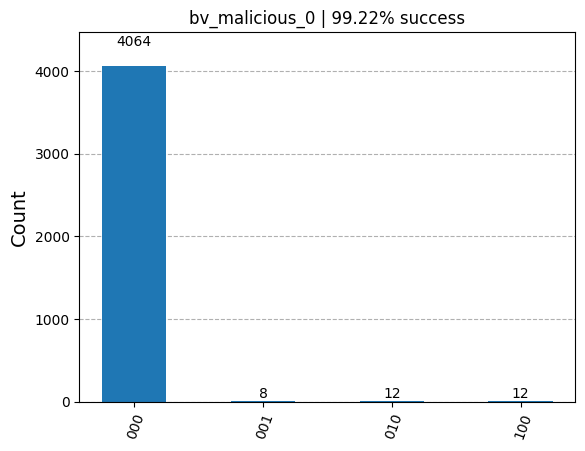

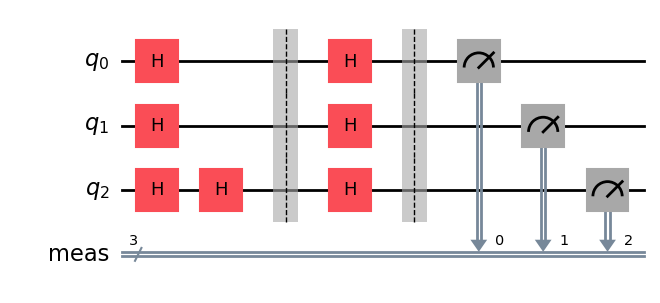

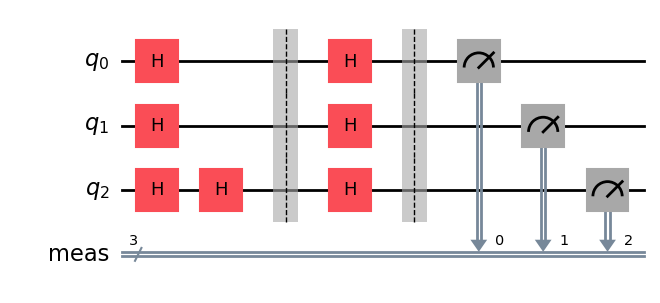

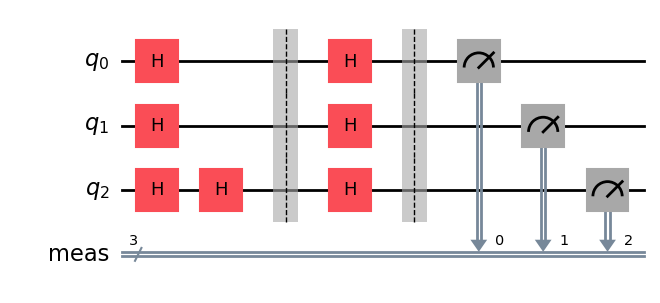

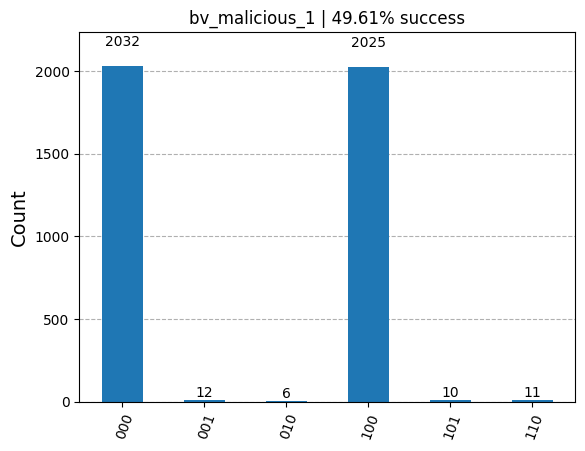

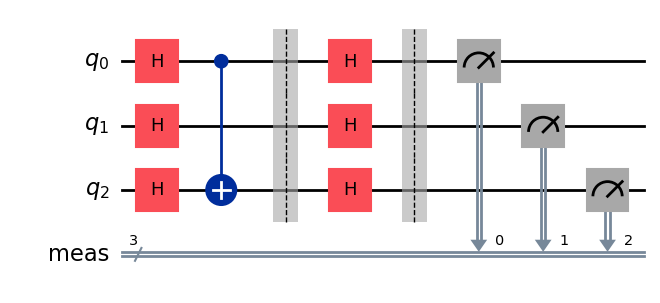

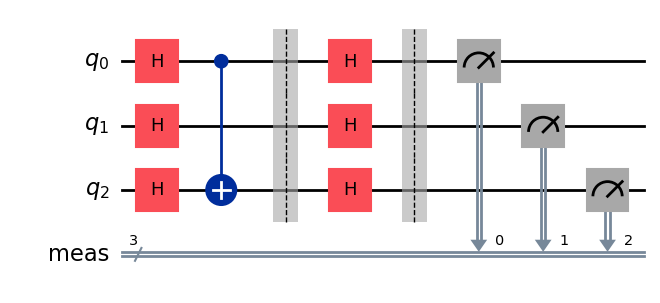

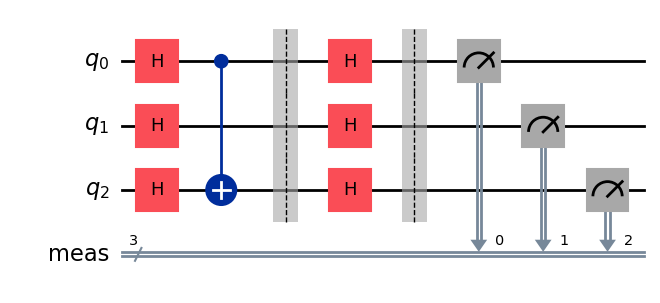

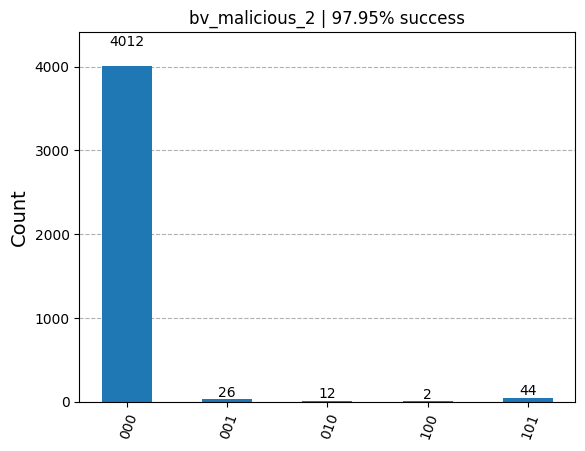

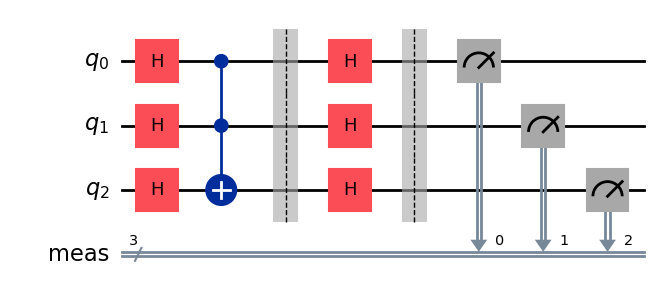

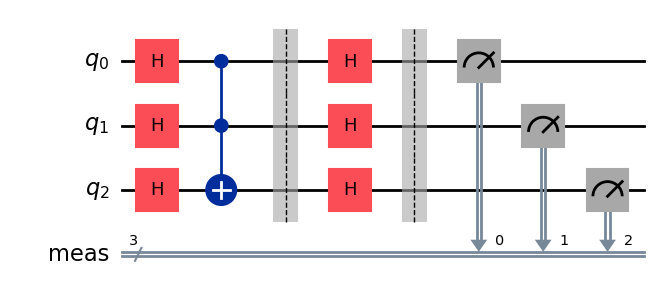

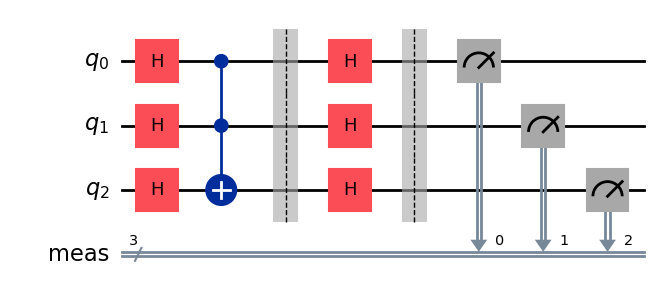

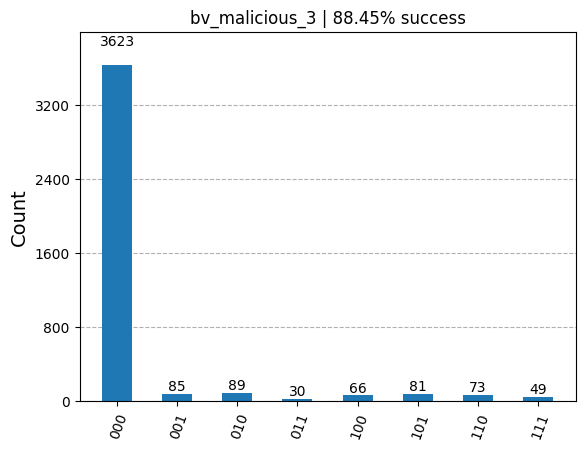

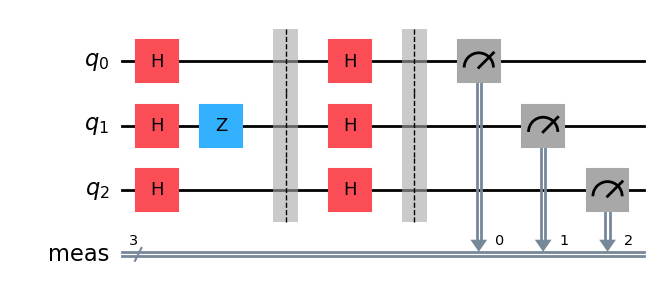

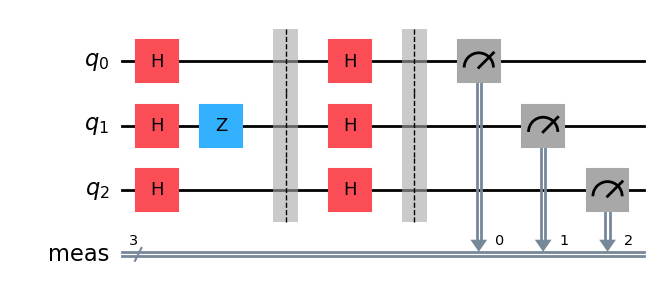

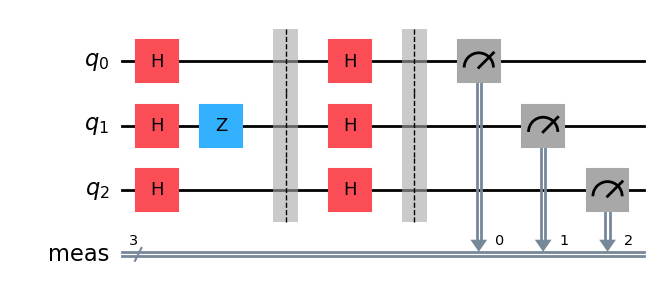

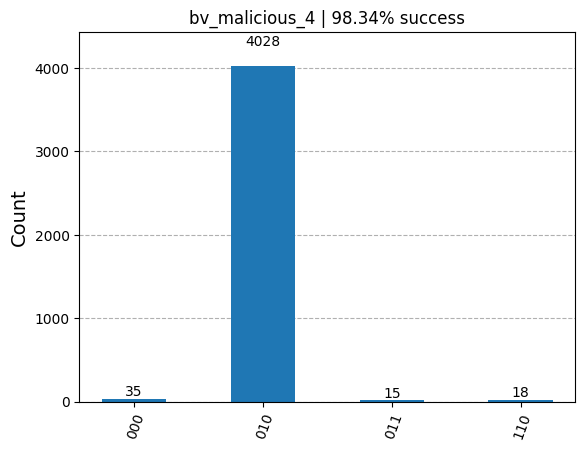

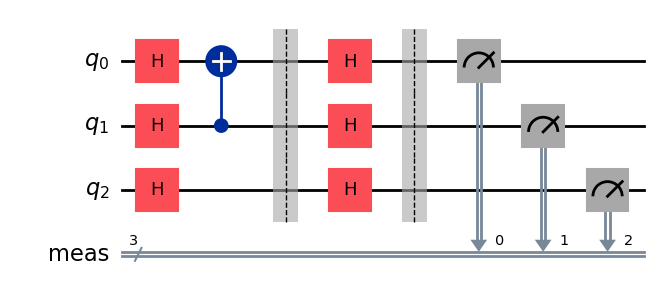

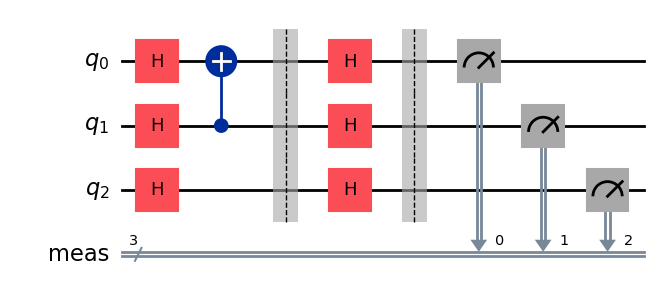

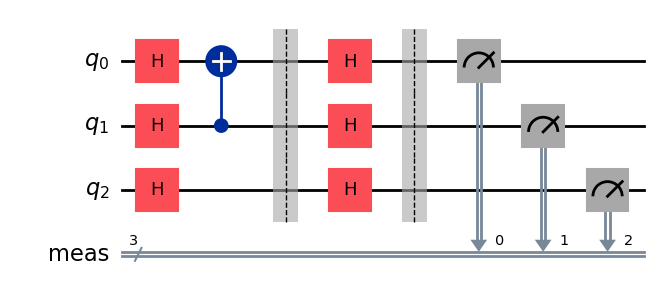

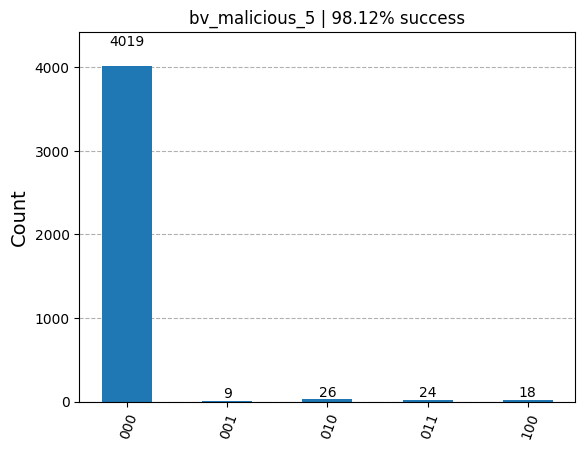

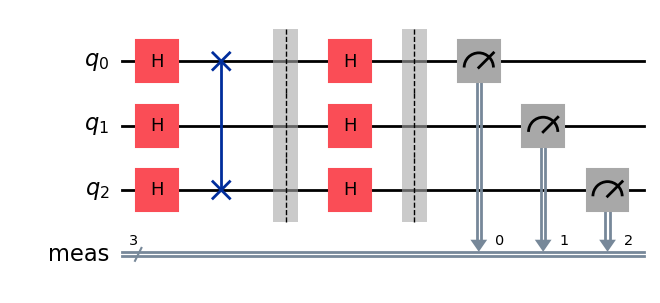

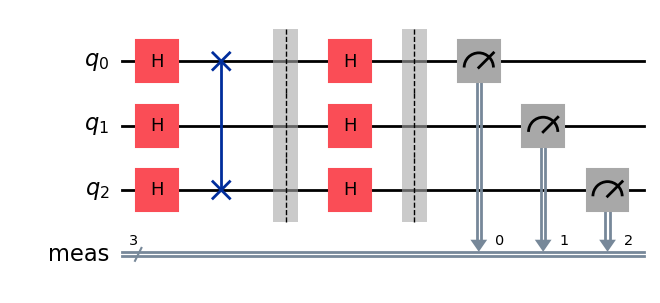

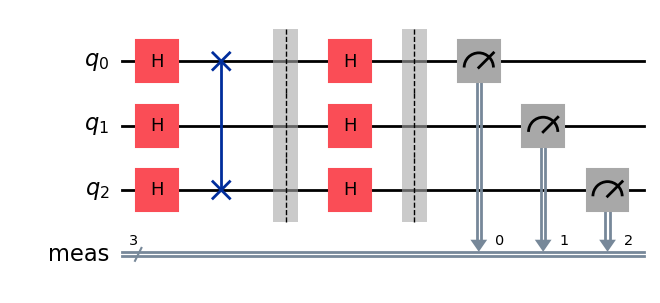

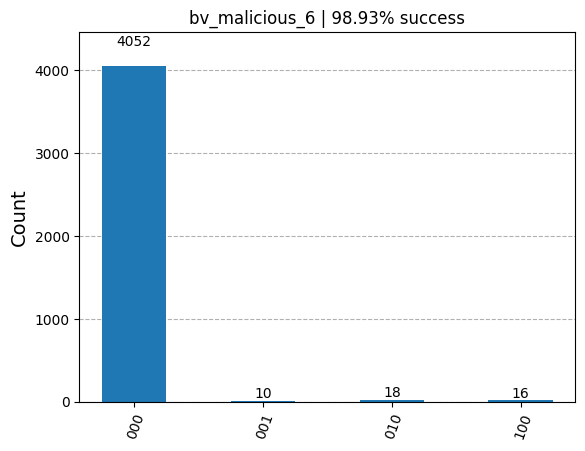

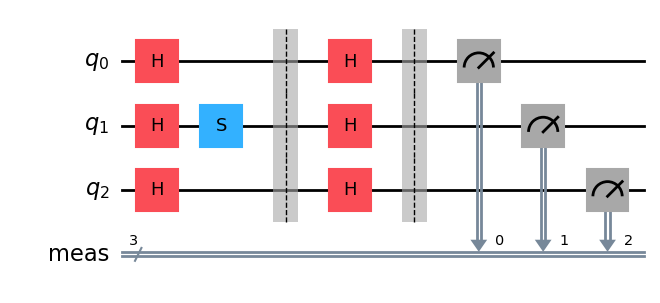

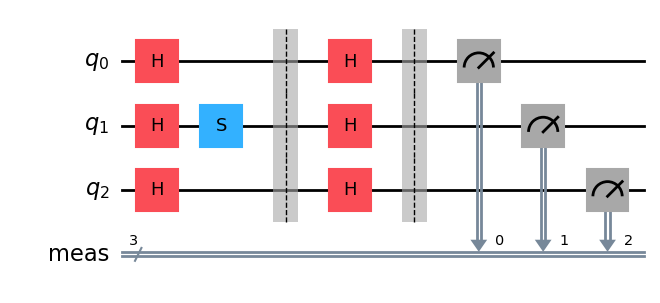

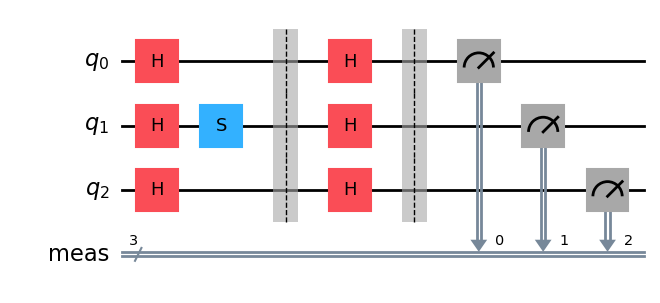

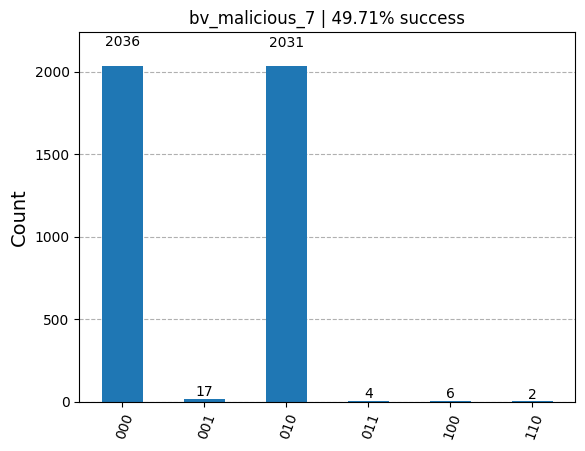

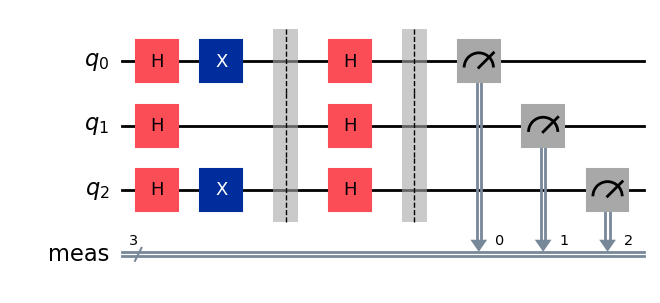

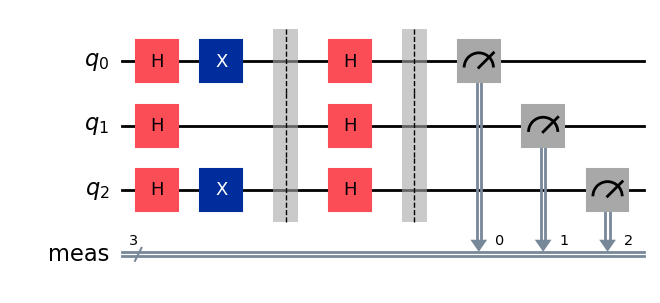

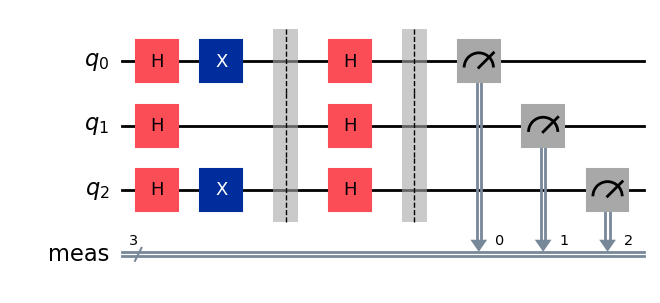

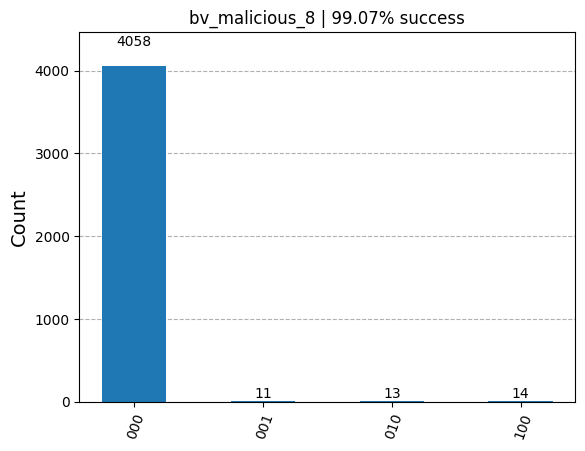

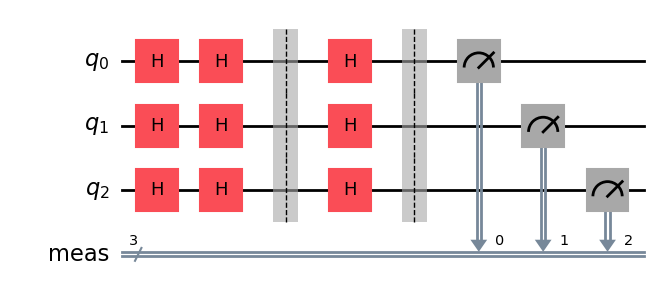

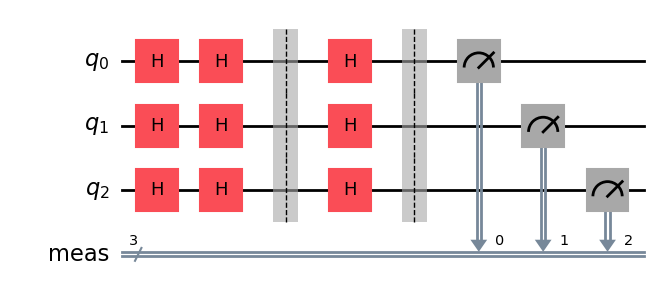

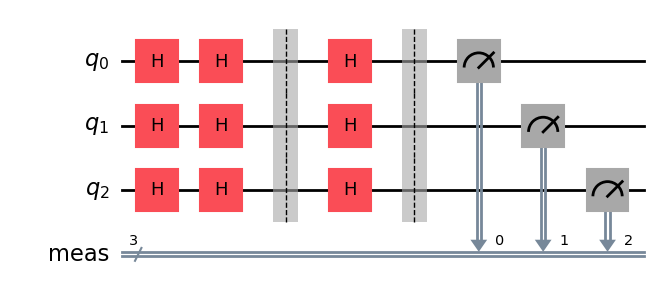

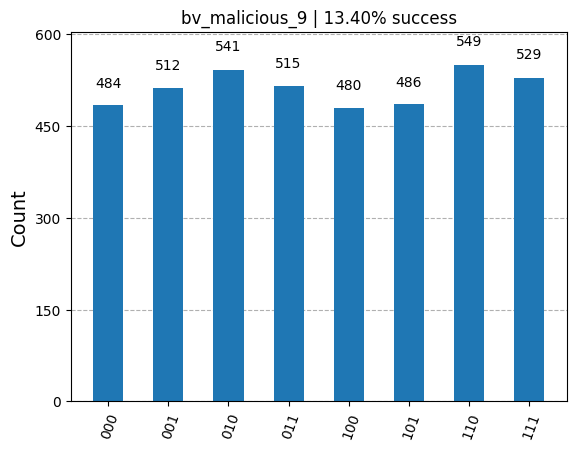

bv_malicious_0 | State: 000 | Success Rate: 99.22%
bv_malicious_1 | State: 000 | Success Rate: 49.61%
bv_malicious_2 | State: 000 | Success Rate: 97.95%
bv_malicious_3 | State: 000 | Success Rate: 88.45%
bv_malicious_4 | State: 010 | Success Rate: 98.34%
bv_malicious_5 | State: 000 | Success Rate: 98.12%
bv_malicious_6 | State: 000 | Success Rate: 98.93%
bv_malicious_7 | State: 000 | Success Rate: 49.71%
bv_malicious_8 | State: 000 | Success Rate: 99.07%
bv_malicious_9 | State: 110 | Success Rate: 13.40%


In [35]:
from qiskit.visualization import plot_histogram
from IPython.display import display
import matplotlib.pyplot as plt
import os

# Create folders if not already there
os.makedirs("bv_malicious_circuits", exist_ok=True)
os.makedirs("bv_malicious_histograms", exist_ok=True)

# Backend
backend = service.backend("ibm_brisbane")

# Execute, visualize, and save
bv_malicious_results = []

for i in range(10):
    name = f"bv_malicious_{i}"
    circuit = bv_malicious_circuits[name]

    # Transpile and execute
    transpiled = transpile(circuit, backend=backend)
    sampler = norm_sampler(backend)
    job = sampler.run([transpiled])
    result = job.result()

    # Extract counts
    try:
        counts = result[0].data.meas.get_counts()
    except:
        counts = result[0].data.c.get_counts()

    # Ensure count values are integers
    counts = {k: int(v) for k, v in counts.items()}

    # Compute success state and success rate
    success_state = max(counts, key=counts.get)
    total_shots = sum(counts.values())
    percentage = (counts[success_state] / total_shots) * 100 if total_shots > 0 else 0

    # Save and show circuit diagram
    circuit.draw("mpl", filename=f"bv_malicious_circuits/{name}.png")
    display(circuit.draw("mpl"))

    # Save and show histogram
    fig = plot_histogram(counts, title=f"{name} | {percentage:.2f}% success")
    fig.savefig(f"bv_malicious_histograms/{name}_hist.png")
    plt.show()

    # Store results
    bv_malicious_results.append({
        "name": name,
        "success_state": success_state,
        "success_rate": percentage
    })

# Print summary
for res in bv_malicious_results:
    print(f"{res['name']} | State: {res['success_state']} | Success Rate: {res['success_rate']:.2f}%")


In [55]:
from qiskit.quantum_info import shannon_entropy

def extract_features(circuit_name, circuit, result, label):
    # Structural features
    ops = circuit.count_ops()
    num_cx = ops.get('cx', 0)
    num_h = ops.get('h', 0)
    num_x = ops.get('x', 0)
    num_ccx = ops.get('ccx', 0)
    depth = circuit.depth()
    total_gates = sum(ops.values())

    # --- FIXED PART FOR SAMPLER OUTPUT ---
    try:
        # Try default classical register name 'meas'
        counts = result[0].data.meas.get_counts()
    except:
        try:
            # Try 'c' if 'meas' not used
            counts = result[0].data.c.get_counts()
        except:
            # If neither works, throw informative error
            print(f"Error in {circuit_name}: classical register name not found.")
            return None
    # --------------------------------------

    # Normalize to probability vector
    probs = np.array(list(counts.values()))
    probs = probs / probs.sum() if probs.sum() != 0 else np.zeros_like(probs)

    # Measurement-based features
    success_state = max(counts, key=counts.get)
    success_rate = (counts[success_state] / sum(counts.values())) * 100 if counts else 0
    entropy = shannon_entropy(probs, base=2)
    unique_states = len(counts)

    return {
        "name": circuit_name,
        "depth": depth,
        "cx": num_cx,
        "h": num_h,
        "x": num_x,
        "ccx": num_ccx,
        "total_gates": total_gates,
        "success_rate": success_rate,
        "entropy": entropy,
        "unique_states": unique_states,
        "label": label
    }


In [56]:
# Prepare container for features
bv_malicious_dataset = []

# Loop through all 10 malicious BV circuits
for i in range(10):
    name = f"bv_malicious_{i}"
    circuit = bv_malicious_circuits[name]

    # Transpile and run
    transpiled = transpile(circuit, backend=backend)
    sampler = norm_sampler(backend)
    job = sampler.run([transpiled])
    result = job.result()

    # Extract metadata/features using fixed function
    features = extract_features(name, circuit, result, label=1)

    # Only append if extraction was successful
    if features:
        bv_malicious_dataset.append(features)

# Convert to DataFrame
df_bv_malicious = pd.DataFrame(bv_malicious_dataset)

# Display and save
print(df_bv_malicious)
df_bv_malicious.to_csv("bv_malicious_dataset.csv", index=False)


             name  depth  cx  h  x  ccx  total_gates  success_rate   entropy  \
0  bv_malicious_0      4   0  6  1    0           12     98.413086  0.141382   
1  bv_malicious_1      4   0  7  0    0           12     50.610352  1.091644   
2  bv_malicious_2      4   1  6  0    0           12     96.972656  0.249488   
3  bv_malicious_3      4   0  6  0    1           12     76.757812  1.377761   
4  bv_malicious_4      4   0  6  0    0           12     97.875977  0.181744   
5  bv_malicious_5      4   1  6  0    0           12     98.071289  0.170646   
6  bv_malicious_6      4   0  6  0    0           12     98.681641  0.121946   
7  bv_malicious_7      4   0  6  0    0           12     50.610352  1.079078   
8  bv_malicious_8      4   0  6  2    0           13     98.754883  0.116184   
9  bv_malicious_9      4   0  9  0    0           14     13.159180  2.999467   

   unique_states  label  
0              4      1  
1              6      1  
2              5      1  
3              

In [57]:
# Merge Clean and Malicious Grover Datasets

import pandas as pd

# Load both datasets
df_clean = pd.read_csv("bv_clean_dataset.csv")
df_malicious = pd.read_csv("bv_malicious_dataset.csv")

# Combine them
df_combined = pd.concat([df_clean, df_malicious], ignore_index=True)

# Display combined shape and preview
print(f"Combined dataset shape: {df_combined.shape}")
display(df_combined.head())

# Save to CSV
df_combined.to_csv("bv_combined_dataset.csv", index=False)


Combined dataset shape: (20, 11)


,name,depth,cx,h,x,ccx,total_gates,success_rate,entropy,unique_states,label
0,bv_clean_0,3,0,7,1,0,11,98.974609,0.098724,4,0
1,bv_clean_1,5,1,7,1,0,12,97.192383,0.219420,5,0
2,bv_clean_2,5,1,7,1,0,12,97.534180,0.200430,4,0
3,bv_clean_3,6,2,7,1,0,13,95.019531,0.373169,6,0
4,bv_clean_4,5,1,7,1,0,12,97.509766,0.197732,5,0


In [58]:
### Dataset Exploration: Class Balance and Feature Correlation
# 
# Before proceeding to model training, it is important to understand the structure and distribution of the dataset. This step includes:
# 
# 1. **Class Balance Visualization**  
# We visualize the distribution of class labels (Clean = 0, Malicious = 1) to ensure that the dataset is not imbalanced. A balanced dataset helps in avoiding biased models that favor the majority class.
# 
# 2. **Feature Correlation Heatmap**  
# A heatmap of feature-to-feature correlation is plotted to identify redundant or highly correlated attributes. This helps in:
#  - Understanding which features carry similar information.
#  - Deciding whether feature reduction or dimensionality techniques are needed.
#  - Revealing potential multicollinearity before model training.
#
# These plots offer insights into dataset quality and are critical for data-driven model design decisions.


C:\Users\zeesh\AppData\Local\Temp\ipykernel_31488\1862799725.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=label_df, palette='Set2')


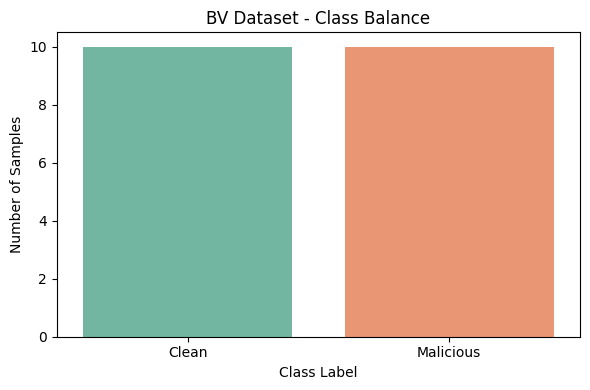

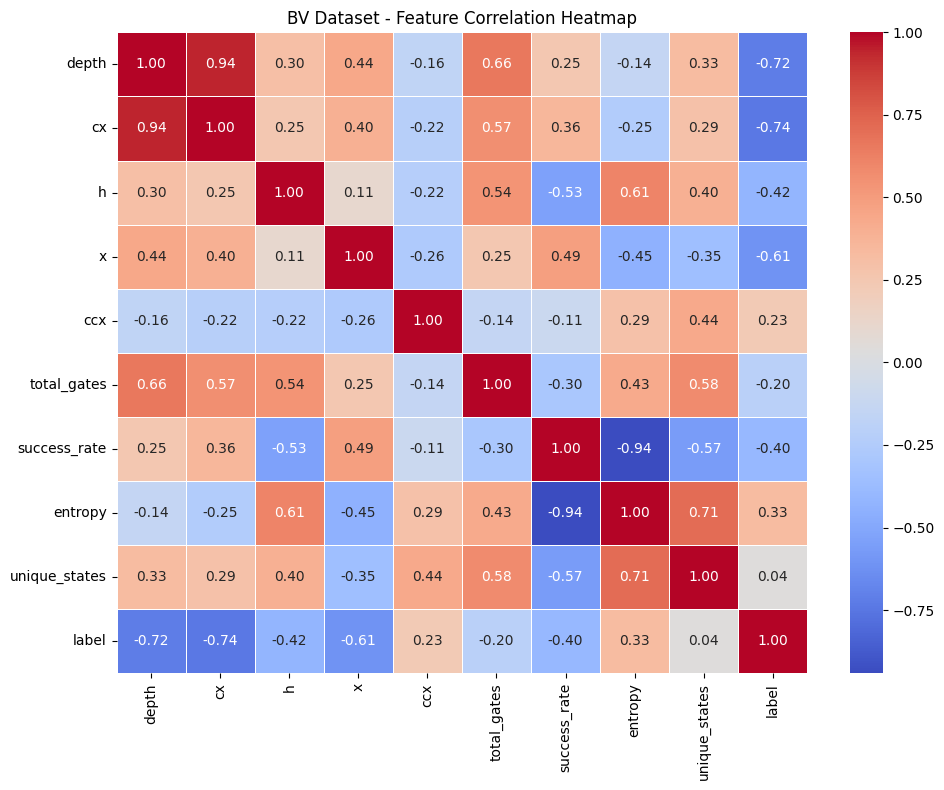

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load BV combined dataset
bv_df = pd.read_csv("bv_combined_dataset.csv")

# Create folder to save plots
os.makedirs("analysis_plots", exist_ok=True)

# ---------- CLASS BALANCE ----------
label_counts = bv_df['label'].value_counts().sort_index()
label_df = pd.DataFrame({
    'Label': ['Clean', 'Malicious'],
    'Count': label_counts.values
})

# Plot Class Balance
plt.figure(figsize=(6, 4))
sns.barplot(x='Label', y='Count', data=label_df, palette='Set2')
plt.title("BV Dataset - Class Balance")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig("analysis_plots/bv_class_balance.png")
plt.show()

# ---------- CORRELATION HEATMAP ----------
plt.figure(figsize=(10, 8))
correlation = bv_df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("BV Dataset - Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("analysis_plots/bv_feature_correlation_heatmap.png")
plt.show()
